In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from yellowbrick.regressor import ResidualsPlot
from datetime import datetime
from sklearn import metrics

In [2]:
def getYearIndex(dataframe, year):
  for i in range(len(dataframe)):
    if dataframe.iloc[i, 0].year == year:
      return i
      break

In [3]:
# import data and create run differential column
gameData = pd.read_csv('result.csv', index_col=0)
gameData['run_differential'] = gameData['home_score'] - gameData['away_score']
for i in range(len(gameData)):
  gameData.iloc[i, 0] = datetime.strptime(gameData.iloc[i, 0], '%Y-%m-%d').date()
gameData.head()

,date,win/loss,home_team,opponent,ΔPE,ΔPE_10d,Log5,Whisnant,ΔOBP,ΔOBP_10d,ΔSLG,ΔSLG_10d,ΔWHIP,ΔWHIP_10d,ΔFIP,ΔSP_ERA,ΔRA_variance,Vegas_Odds,home_moneyline,home_score,away_score,away_team,moneyline,outcome,prediction,right/wrong,run_differential
0,2011-07-05,1.0,Pittsburgh Pirates,Houston Astros,0.112376,0.173056,0.678390,0.487362,-0.00226,0.02505,-0.02195,-0.00245,-0.1074,-0.33554,-0.25961,-0.32,0.627287,NaN,-110.0,5.0,1.0,HOU,0.523810,1.0,1.0,1.0,4.0
1,2011-07-05,0.0,Chicago White Sox,Kansas City Royals,0.057464,-0.276411,0.600000,0.465700,-0.01046,-0.04832,-0.00975,-0.11011,-0.1715,-0.45601,-0.89458,0.18,0.226833,NaN,-145.0,3.0,5.0,KC,0.591837,0.0,1.0,0.0,-2.0
2,2011-07-05,0.0,Los Angeles Dodgers,New York Mets,-0.060112,-0.522949,0.424474,0.432308,-0.01361,-0.04924,-0.01581,-0.08220,-0.0157,-0.41377,-0.40312,0.05,-0.087979,NaN,-130.0,0.0,6.0,NYM,0.565217,0.0,1.0,0.0,-6.0
3,2011-07-05,1.0,St. Louis Cardinals,Cincinnati Reds,-0.015314,-0.093653,0.534880,0.494705,0.01016,-0.00726,0.01269,-0.01956,-0.0122,0.05949,-0.46253,-2.32,-0.365017,NaN,-135.0,8.0,1.0,CIN,0.574468,1.0,1.0,1.0,7.0
4,2011-07-05,0.0,Milwaukee Brewers,Arizona D'Backs,-0.004684,0.165294,0.488342,0.488185,0.00105,0.01097,-0.00123,0.03241,-0.0219,-0.00547,-0.27411,-2.59,-0.416325,NaN,-150.0,3.0,7.0,ARI,0.600000,0.0,1.0,0.0,-4.0


In [4]:
# create matrices for Ax = b
A = gameData.iloc[:,4:17] 
A['moneyline'] = gameData.loc[:,'moneyline']
A

,ΔPE,ΔPE_10d,Log5,Whisnant,ΔOBP,ΔOBP_10d,ΔSLG,ΔSLG_10d,ΔWHIP,ΔWHIP_10d,ΔFIP,ΔSP_ERA,ΔRA_variance,moneyline
0,0.112376,0.173056,0.678390,0.487362,-0.00226,0.02505,-0.02195,-0.00245,-0.1074,-0.33554,-0.25961,-0.32,0.627287,0.523810
1,0.057464,-0.276411,0.600000,0.465700,-0.01046,-0.04832,-0.00975,-0.11011,-0.1715,-0.45601,-0.89458,0.18,0.226833,0.591837
2,-0.060112,-0.522949,0.424474,0.432308,-0.01361,-0.04924,-0.01581,-0.08220,-0.0157,-0.41377,-0.40312,0.05,-0.087979,0.565217
3,-0.015314,-0.093653,0.534880,0.494705,0.01016,-0.00726,0.01269,-0.01956,-0.0122,0.05949,-0.46253,-2.32,-0.365017,0.574468
4,-0.004684,0.165294,0.488342,0.488185,0.00105,0.01097,-0.00123,0.03241,-0.0219,-0.00547,-0.27411,-2.59,-0.416325,0.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17950,0.171002,-0.107356,0.678307,0.592622,0.02876,-0.01592,0.05014,-0.04985,-0.0754,0.26351,-1.27734,-3.91,0.831274,0.754300
17951,-0.032996,0.154866,0.424606,0.465258,-0.00857,0.00797,-0.01039,0.06714,-0.0515,0.07389,-0.30324,1.70,-0.103719,0.534884
17952,-0.139157,0.092240,0.319915,0.472948,-0.02113,0.01019,-0.00425,0.03649,0.2598,0.36434,1.19332,2.79,-0.398356,0.341297
17953,-0.152471,-0.103326,0.340449,0.427517,-0.02087,0.01428,-0.06016,-0.00498,0.1644,0.53308,0.38177,-0.48,-0.551985,0.425532


In [5]:
b = gameData.loc[:,'run_differential']
b

0        4.0
1       -2.0
2       -6.0
3        7.0
4       -4.0
        ... 
17950    1.0
17951    1.0
17952    5.0
17953    5.0
17954    6.0
Name: run_differential, Length: 17955, dtype: float64

In [6]:
training_A = A[:getYearIndex(gameData, 2018)]
test_A = A[getYearIndex(gameData, 2018):]
training_b = b[:getYearIndex(gameData, 2018)]
test_b = b[getYearIndex(gameData, 2018):]

In [7]:
training_A_inverse = pd.DataFrame(np.linalg.pinv(training_A.values), training_A.columns, training_A.index)

In [8]:
# check to make sure that A x A_inverse = Identity Matrix
training_A_inverse.dot(training_A).head()

,ΔPE,ΔPE_10d,Log5,Whisnant,ΔOBP,ΔOBP_10d,ΔSLG,ΔSLG_10d,ΔWHIP,ΔWHIP_10d,ΔFIP,ΔSP_ERA,ΔRA_variance,moneyline
ΔPE,1.000000e+00,-1.658396e-15,1.087672e-15,-1.049508e-15,-1.179612e-16,2.404760e-16,-6.337975e-16,-2.042637e-16,-2.669306e-16,7.389922e-16,-6.123574e-16,1.082467e-15,-1.868297e-15,1.283695e-16
ΔPE_10d,3.318743e-16,1.000000e+00,2.745200e-16,4.458239e-16,1.062349e-16,-1.747734e-16,3.103529e-16,1.884072e-16,-3.881444e-17,5.117434e-17,-1.279359e-16,1.087238e-15,6.110563e-16,1.691355e-16
Log5,-2.428613e-17,2.776642e-16,1.000000e+00,5.724587e-17,-5.487147e-16,-3.144186e-18,3.503328e-16,1.095044e-17,2.354887e-16,3.419574e-16,-7.407269e-16,-2.289835e-15,3.955170e-16,-1.007874e-15
Whisnant,1.388863e-16,1.109789e-15,1.020017e-15,1.000000e+00,1.560980e-16,2.450297e-17,-2.604796e-16,1.724830e-16,8.283305e-17,-4.839878e-16,2.133710e-15,2.740863e-16,1.477117e-15,3.538836e-16
ΔOBP,-6.279699e-16,4.850287e-15,2.636780e-15,4.551914e-15,1.000000e+00,-4.770490e-17,9.306791e-16,7.589415e-17,2.563921e-15,-1.387779e-15,6.272760e-15,-2.470246e-15,7.494005e-15,3.663736e-15


In [9]:
# x* = (A_transpose x A)^-1 * A_transpose x b
Atranspose_A = (training_A.transpose().dot(training_A))
Atranspose_A_inverse = pd.DataFrame(np.linalg.pinv(Atranspose_A.values), Atranspose_A.columns, Atranspose_A.index)
x_star = (Atranspose_A_inverse.dot(training_A.transpose())).dot(training_b)
x_star

ΔPE              6.070140
ΔPE_10d          0.341036
Log5            -3.235293
Whisnant        -8.138647
ΔOBP             5.964786
ΔOBP_10d        -1.480462
ΔSLG             3.526747
ΔSLG_10d        -0.719059
ΔWHIP            1.158481
ΔWHIP_10d       -0.457091
ΔFIP             0.284098
ΔSP_ERA          0.000292
ΔRA_variance    -0.048634
moneyline       10.567578
dtype: float64

In [10]:
# alternative method to solve x* = (A_transpose x A)^-1 * A_transpose x y
beta_hat = np.linalg.inv(training_A.T.dot(training_A)).dot(training_A.T).dot(training_b)
beta_hat

array([ 6.07014039e+00,  3.41035597e-01, -3.23529337e+00, -8.13864684e+00,
        5.96478648e+00, -1.48046231e+00,  3.52674735e+00, -7.19059454e-01,
        1.15848092e+00, -4.57090609e-01,  2.84097509e-01,  2.92310553e-04,
       -4.86340991e-02,  1.05675778e+01])

In [11]:
training_predictions = training_A.dot(x_star)
test_predictions = test_A.dot(x_star)

In [13]:
print('Model Errors:')
print('Training Set Mean Squared Error:', round(metrics.mean_squared_error(training_b, training_predictions),3))
print('Test Set Mean Squared Error:', round(metrics.mean_squared_error(test_b, test_predictions),3))
print('------------------------------------------')
print('Training Set Mean Absolute Error:', round(metrics.mean_absolute_error(training_b, training_predictions),3))
print('Test Set Mean Absolute Error:', round(metrics.mean_absolute_error(test_b, test_predictions),3))
print('------------------------------------------')
print('Training Set Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(training_b, training_predictions)),3))
print('Test Set Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(test_b, test_predictions)),3))

Model Errors:
Training Set Mean Squared Error: 17.344
Test Set Mean Squared Error: 19.803
------------------------------------------
Training Set Mean Absolute Error: 3.263
Test Set Mean Absolute Error: 3.447
------------------------------------------
Training Set Root Mean Squared Error: 4.165
Test Set Root Mean Squared Error: 4.45


In [ ]:
regression = LinearRegression()
X_test = test_A
X_train = training_A
regression.fit(X_train, training_b)
regressionTrain = regression.predict(X_train)
regressionTest = regression.predict(X_test)
print('Training Set Mean Squared Error:', round(metrics.mean_squared_error(training_b, regressionTrain),3))
print('Test Set Mean Squared Error:', round(metrics.mean_squared_error(test_b, regressionTest),3))
print('------------------------------------------')
print('Training Set Mean Absolute Error:', round(metrics.mean_absolute_error(training_b, regressionTrain),3))
print('Test Set Mean Absolute Error:', round(metrics.mean_absolute_error(test_b, regressionTest),3))
print('------------------------------------------')
print('Training Set Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(training_b, regressionTrain)),3))
print('Test Set Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(test_b, regressionTest)),3))

Training Set Mean Squared Error: 17.316
Test Set Mean Squared Error: 19.785
------------------------------------------
Training Set Mean Absolute Error: 3.262
Test Set Mean Absolute Error: 3.443
------------------------------------------
Training Set Root Mean Squared Error: 4.161
Test Set Root Mean Squared Error: 4.448


In [14]:
print('MoneyLine Errors:')
regression = LinearRegression()
x = test_A['moneyline']
X_test = x[:,np.newaxis]
x = training_A['moneyline']
X_train = x[:,np.newaxis]
regression.fit(X_train, training_b)
regressionTrain = regression.predict(X_train)
regressionTest = regression.predict(X_test)
print('Training Set Mean Squared Error:', round(metrics.mean_squared_error(training_b, regressionTrain),3))
print('Test Set Mean Squared Error:', round(metrics.mean_squared_error(test_b, regressionTest),3))
print('------------------------------------------')
print('Training Set Mean Absolute Error:', round(metrics.mean_absolute_error(training_b, regressionTrain),3))
print('Test Set Mean Absolute Error:', round(metrics.mean_absolute_error(test_b, regressionTest),3))
print('------------------------------------------')
print('Training Set Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(training_b, regressionTrain)),3))
print('Test Set Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(test_b, regressionTest)),3))
print('                                           ')

MoneyLine Errors:
Training Set Mean Squared Error: 17.34
Test Set Mean Squared Error: 19.747
------------------------------------------
Training Set Mean Absolute Error: 3.264
Test Set Mean Absolute Error: 3.437
------------------------------------------
Training Set Root Mean Squared Error: 4.164
Test Set Root Mean Squared Error: 4.444
                                           


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


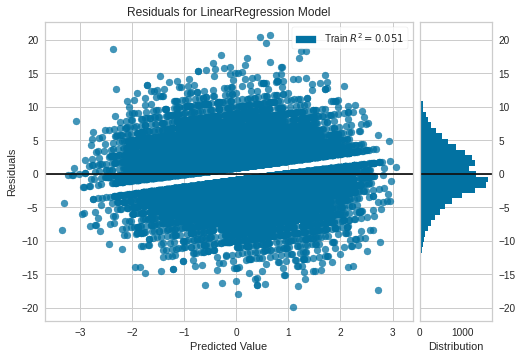

In [ ]:
visualize = ResidualsPlot(regression)
visualize.fit(A, b)
visualize.poof()